# Expressivity as an Information Theoretic-measure 
### of 
## Quantum Circuits' representational capacity / AutoEncoder effectiveness

| Layer                 | Measure                      | What It Captures                                                      | Why It Matters                                                     |
| --------------------- | ---------------------------- | --------------------------------------------------------------------- | ------------------------------------------------------------------ |
| **Global Capacity**   | **Hilbert-Schmidt**     | Circuit's ability to cover unitary space (like entropy or dispersion) | Tells us what the model *could* express - capacity ceiling        |
| **Local Sensitivity** | **Fisher Information**       | How responsive output is to infinitesimal parameter changes           | Tells us how easily the model can be trained - learnability floor |
| **Task Relevance**    | **Mutual Information**  | How much input info is retained or transformed                        | Tells us whether the model expresses *useful* data features       |
| **Generalization**    | **Effective Dimension** | How rich and learnable the function class is given data               | Tells us how much data would be needed to learn a classifier in this feature space     |


In [1]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)

### Dataset

- Simple binary-classification dataset with two Gaussian clusters centered at opposite corners

- The features are then scaled to the range [-pi, pi] for quantum rotation gates

- Highly visualisable -> clear metric inference

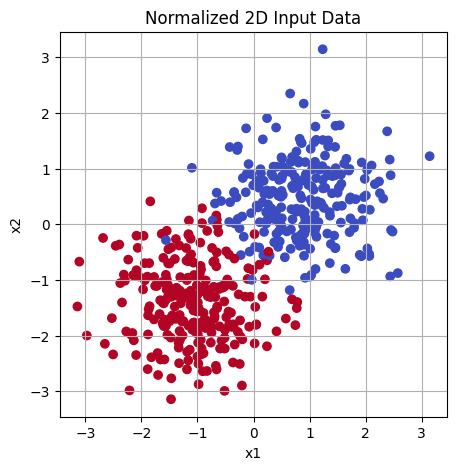

In [2]:
X, y = make_blobs(n_samples=512, centers=[[1,1], [-1,-1]], cluster_std=0.75)
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))  # Normalize to [-pi, pi]
X = scaler.fit_transform(X)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
plt.title("Normalized 2D Input Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()

## Quantum Circuit

In [3]:
# Config: Simple, Shallow
n_qubits = 2
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

(<Figure size 1200x300 with 1 Axes>, <Axes: >)

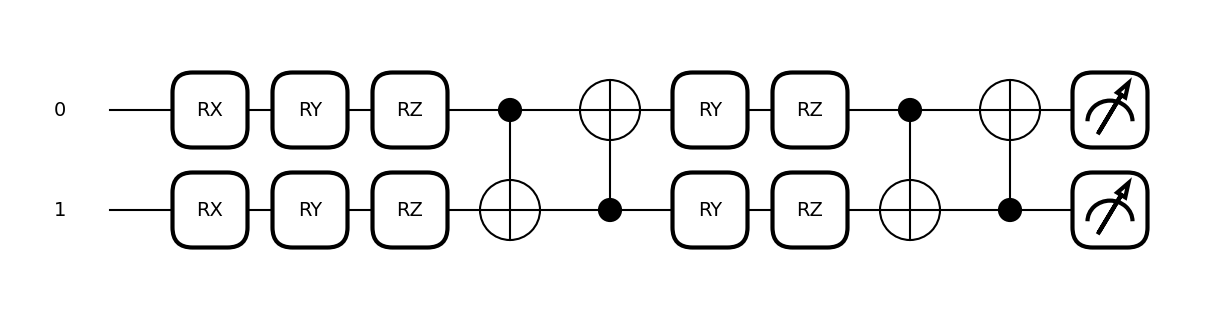

In [4]:
@qml.qnode(dev, interface='jax')
def encoding_circuit(inputs):
    # Angle embedding
    for i in range(n_qubits):
        qml.RX(inputs[i], wires=i)
    
    # Entangling layers
    for _ in range(n_layers):
        for i in range(n_qubits):
            qml.RY(inputs[i], wires=i)
            qml.RZ(inputs[i], wires=i)
        for i in range(n_qubits):  # ring entanglement
            qml.CNOT(wires=[i, (i+1) % n_qubits]) 

    return qml.state() # Return full statevector (for fidelity, inner products, etc.)

qml.draw_mpl(encoding_circuit)(["random", "stuff", "works", "nice"])

In [5]:
print("Encodeding Example:\n")
for i in range(5):
    x_sample = X[i]
    state = encoding_circuit(x_sample)
    print(f"x = {x_sample}")
    print(f"|ψ⟩ = {np.round(state, 3)}\n")

# Encoding
states = np.array([encoding_circuit(x) for x in X])

Encodeding Example:

x = [-1.46512572 -1.17359693]
|ψ⟩ = [-0.46500003-0.768j      -0.123     -0.36100003j  0.022     +0.j
 -0.21900001+0.015j     ]

x = [ 2.06507422 -0.56994031]
|ψ⟩ = [ 0.42900002-0.34300002j -0.37500003+0.623j      -0.059     +0.31100002j
  0.028     -0.263j     ]

x = [-1.67562908 -1.61256959]
|ψ⟩ = [ 0.143-0.98200005j  0.051+0.041j      -0.105+0.006j
  0.017-0.003j     ]

x = [-1.59947963 -1.42034249]
|ψ⟩ = [-0.11800001-0.97800004j  0.003     -0.149j      -0.039     -0.001j
 -0.07      -0.002j     ]

x = [ 1.43888723 -0.20407965]
|ψ⟩ = [0.48900002-0.386j      0.246     +0.4j        0.256     +0.27400002j
 0.32000002-0.384j     ]



#### ^ $\mathbb{C}^4$ normalised vector: $|\psi>$ = [$c_0,~c_1,~c_2,~c_4$]

---

### Hilbert-Schmidt Expressivity Measure || Global Measure

It quantifies how well a quantum circuit covers the Hilbert space as its input parameters vary.

If it covers Hilbert space broadly, then it's expressive. If it only visits a small region, it's not expressive.

How to compare? With a uniform, random distriution of the space -> **Haar Random Distribution**: Haar-random circuits maximize entropy, span the full space, and are maximally expressive

> How close is the distribution of quantum states generated by our encoder to the Haar distribution?

**Formal Definiton from Sim et al. paper**

Expressibility Metric, $\mathcal{E}$, is defined as the closeness between the distribution of fidelities over the parameterized quantum circuit and the distribution of fidelities from Haar-random unitaries.

$$
\mathcal{E} = \int dU_1 \int dU_2 \left[ \mathrm{Pr}_{\text{circuit}}(F(U_1, U_2)) - \mathrm{Pr}_{\text{Haar}}(F(U_1, U_2)) \right]^2
$$

where,
* $U_1, U_2$: Unitaries (transformation matrices) produced by the quantum circuit at two different inputs.

* $F(U_1, U_2) = \left| \frac{1}{d}\;\mathrm{Tr}(U_1^\dagger\;U_2) \right|^2$: Hilbert-Schmidt fidelity (overlap of actions) -> measure of similarity of the two || This gives the global measure

* d = dimension = $2^n$; $F=1$ -> Exactly Equal, $F\approx0$ -> orthogonal (very different) {Kind of like dot product for matrices}. We want $F$ to be **LOW** meaning more diversity

* $\mathrm{Pr}_{\text{circuit}}(F)$: Distribution of fidelities from the **parametric quantum circuit**.

* $\mathrm{Pr}_{\text{Haar}}(F)$: Distribution of fidelities from **Haar-random unitaries**.

This is like $L^2$ distance between our space spanning, and Haar spacec spanning. We want to minimise this distance so that we remain close to a complete space span (Haar).

> $\mathcal{E}$ is low -> High Expressivity

In our case, we have an encoder circuit:

$$
U: x \mapsto |\psi(x)\rangle
$$

We can **compare states instead of unitaries**. For pure states, the fidelity becomes:

$$
F(\psi, \phi) = |\langle \psi | \phi \rangle|^2
$$

We now treat $\mathrm{Pr}_{\text{circuit}}(F)$ as the empirical distribution of state fidelities from your circuit, and compare it to the theoretical distribution of Haar-random pure-state fidelities.

This is computationally easier than working with unitaries.

To compute the full $\mathcal{E}$, we need:

1. Large number of samples from the circuit to build exact distribution
2. Theoretical Haar distribution of fidelities
3. Statistical comparison.

This is costly in high-dimensional spaces.

<br>

Simplifying, 

we compute the **average pairwise fidelity**:
$$
\bar{F} = \frac{2}{N(N-1)} \sum_{i < j} |\langle \psi_i | \psi_j \rangle|^2
$$

Then,
* If the average fidelity is **close to 1**, states are similar -> low expressivity.

* If it’s **close to the Haar value**, $E[F] = \frac{1}{d}$, our circuit is expressive.

$i<j$ prevents self comparisons and double countings. S, exactly $\binom{N}{2}=\frac{N(N-1)}{2}~$ in a system with N states

Average Pairwise Fidelity (Circuit): 0.3842
Expected Haar Average Fidelity: 0.2500

!!Moderate expressivity: circuit generates somewhat diverse states.


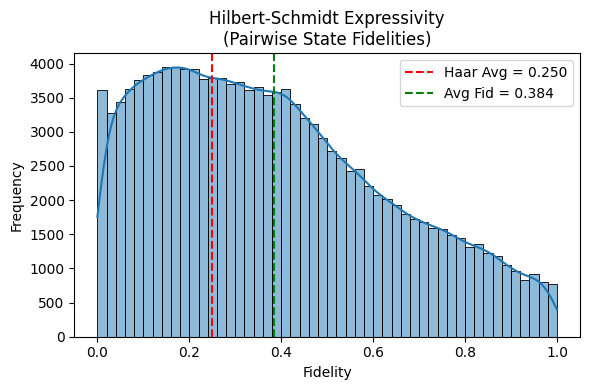

In [6]:
def get_pairwise_fidelities(states):
    N = len(states)
    fids = []
    for i in range(N):
        for j in range(i+1, N):
            fid = np.abs(np.vdot(states[i], states[j]))**2
            fids.append(fid)
    return np.array(fids)
fidelities = get_pairwise_fidelities(states)

avg_fidelity = np.mean(fidelities)
haar_avg = 1 / (2**n_qubits)


print(f"Average Pairwise Fidelity (Circuit): {avg_fidelity:.4f}")
print(f"Expected Haar Average Fidelity: {haar_avg:.4f}")

# Thresholding acc. to Sim et al.
if avg_fidelity < haar_avg*1.5: print("\n!!!High expressivity: circuit spans state space similar to Haar-random states.")  
elif avg_fidelity<0.6: print("\n!!Moderate expressivity: circuit generates somewhat diverse states.")
else: print("\n!Low expressivity: circuit encodes very similar or redundant states.")

plt.figure(figsize=(6, 4))
sns.histplot(fidelities, bins=50, kde=True)
plt.axvline(haar_avg, color='red', linestyle='--', label=f"Haar Avg = {haar_avg:.3f}")
plt.axvline(avg_fidelity, color='green', linestyle='--', label=f"Avg Fid = {avg_fidelity:.3f}")
plt.title("Hilbert-Schmidt Expressivity\n(Pairwise State Fidelities)")
plt.xlabel("Fidelity")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

* The graph shows pair-wise fidelity on the x-axis

* The circuit produces meany states pairs with low fiedlities which is a good sign

Let's see if this expressivity turned into separability by our encoder in state space

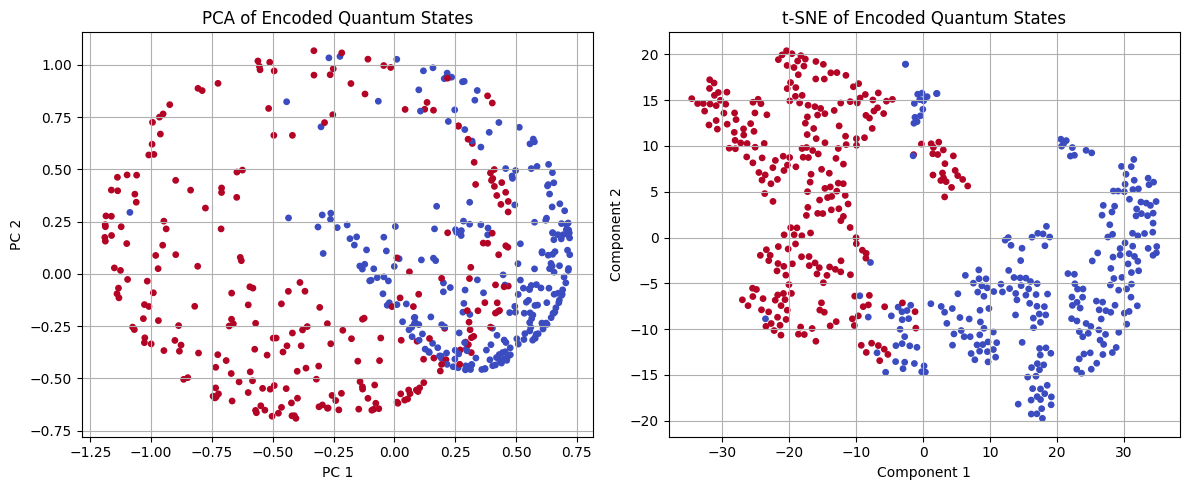

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Convert complex quantum states to real-valued vectors
real_states = np.concatenate([np.real(states), np.imag(states)], axis=1)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(real_states)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='random', random_state=42)
X_tsne = tsne.fit_transform(real_states)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm", s=15)
axs[0].set_title("PCA of Encoded Quantum States")
axs[0].set_xlabel("PC 1")
axs[0].set_ylabel("PC 2")
axs[0].grid(True)

axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="coolwarm", s=15)
axs[1].set_title("t-SNE of Encoded Quantum States")
axs[1].set_xlabel("Component 1")
axs[1].set_ylabel("Component 2")
axs[1].grid(True)

plt.tight_layout()
plt.show()

PCA captures global strucre of the data. Since we are projecting Hilbert Space onto a 2D map we see a ring/toroid/spher/circle/this shape. It is showing variancle across top 2 linear directions. This might mean circuit maps inputs nonlinearly which is good for expressivity. To confirm we look at t-SNE which further convers this manifold.

t-SNE preserves neighbours in high-dimensional space as neighbours in 2D projection -> local similarity -> better visualisation of high-expressivity, nonlinear encoding. We can clearly see separable classes (with minor overlaps due to a small circuit). So, the circuit is encoding with sufficient expressivty.

---

## Fischer Information

Measures how much the state changes with *infinitismal* changes in input; thus, denoting how much information it carries with it

The **QFI matrix** quantifies **how sensitively a quantum state changes** with respect to changes in parameters (here: the encoded classical input $\mathbf{x}$). It is the quantum generalization of the classical Fisher Information.

We have, $\mathbf{x} = (x_1, x_2, \dots, x_d) \in \mathbb{R}^d$, the classical data encoded into a quantum state $|\psi(\mathbf{x})\rangle \in \mathbb{C}^{2^n}$, produced by a quantum circuit.

Then the **QFI matrix** $F\in\mathbb{R}^{d\times d}$ is defined (for pure states) as:

$$
F_{ij} = 4 \left[ \Re \langle \partial_i \psi | \partial_j \psi \rangle - \langle \psi | \partial_i \psi \rangle \langle \partial_j \psi | \psi \rangle \right]
$$

where,
* $|\psi\rangle = |\psi(\mathbf{x})\rangle$

* $|\partial_i \psi\rangle = \frac{\partial}{\partial x_i} |\psi(\mathbf{x})\rangle$

* $\Re$ denotes the **real part** of the complex number

* The dot products are complex inner products:
  $\langle a | b \rangle = \sum_k a_k^* b_k$

<br>

Elements of the QFI matrix

* **Diagonal**: $F_{ii}$ = How much the quantum state changes when we perturb $x_i$.

* **Off-diagonal**: $F_{ij}$ = Whether the changes in $x_i$ and $x_j$ interfere or couple. Strong off-diagonals mean **input variables are entangled/non-separable**.

Given the matrix $F$, we compute its **eigenvalues** $\lambda_1, \dots, \lambda_d$, and eigenvectors $v_1, \dots, v_d$, such that:

$$
F v_k = \lambda_k v_k
$$

* Each $\lambda_k$ tells us **how much the circuit responds** when you move in the input space along direction $v_k$.

* If $\lambda_k = 0$, it means **no change in the state** when you move in that direction → completely insensitive.

<br>

| Case                   | Meaning                       | Effect                         |
| --------------------------- | ----------------------------- | ------------------------------ |
| All $\lambda_i > 0$         | All directions sensitive      | Expressive and trainable       |
| Some $\lambda_i = 0$        | Flat in some input directions | Unlearnable directions         |
| One $\lambda_i \gg$ rest    | Too sensitive to one input    | Poor conditioning, overfitting |
| Large off-diagonal $F_{ij}$ | Inputs are strongly entangled | Feature entanglement           |


This interpretability also makes it useful in loss training, for finding barren plateus

$$
F(x) = 4 \left[ \underbrace{\langle \partial_x \psi | \partial_x \psi \rangle}_{\text{Change of state}} - \underbrace{|\langle \psi | \partial_x \psi \rangle|^2}_{\text{Global phase term (removable)}} \right]
$$

* $\langle \partial_x \psi | \partial_x \psi \rangle$ measures the **total change** in the quantum state (including global phase).

* $|\langle \psi | \partial_x \psi \rangle|^2$ removes the **unphysical global phase** component of that change.

* The subtraction isolates the **physical** change in the **direction** of the state vector in Hilbert space.


For input vector $\mathbf{x} = (x_1, x_2, \dots, x_d)$, we can define:

$$
F_{ij} = 4 \left[ \Re \left( \langle \partial_i \psi | \partial_j \psi \rangle \right) - \langle \partial_i \psi | \psi \rangle \langle \psi | \partial_j \psi \rangle \right]
$$

This gives a full QFI matrix measuring local curvature in each direction $x_i, x_j$.

> Apparently, it is something like a Riemann(ian) Metric, or a measure of distance and angles on curved surfaces

The effectiveness of any estimator or encoder, $\hat{x}$, encoding/estimating data, $x$, is bound by its Fischer Information (Cramer-Rao Bound),

$$
Var(x)  \ge \frac{1}{F(x)}
$$

Since, $F(x)$ is information-measure of how much information the data of $\hat{x}$ carries about $x$ -> bounds the minimum possible variance of the encoder.  

The more sensitive $\hat{x}$ is to $x,$ (high $F(x)$), the smaller is the minimum possible variance in estimating it.


Mean QFI matrix:
 [[2.5036905  0.04971469]
 [0.04971469 2.6998775 ]]

Eigenvalues of QFI: [2.49180007 2.7118001]

Eigenvectors:
 [[-0.9726213   0.23239565]
 [ 0.23239565  0.9726213 ]]


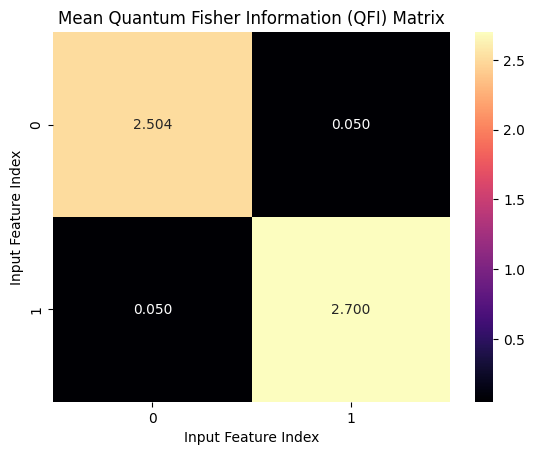

In [8]:
import jax
import jax.numpy as jnp
def compute_qfi(encoding_circuit, x):
    psi = encoding_circuit(x)  # complex statevector, shape (2**n,)
    
    # for complex differentiation using vector jacobian product
    y, vjp_fn = jax.vjp(encoding_circuit, x)    # y,  fn = vjp(f, x) : y -> f(X), fn : v --> v^T . J 

    eye = jnp.eye(y.shape[0], dtype=complex) # I_d \in C^{d x d}, where each row, e_k, is a basis vector
    
    # Compute Jacobian rows using VJP
    jac_rows = [vjp_fn(e)[0] for e in eye] # gradient of \psi in direction e_k
    jac = jnp.stack(jac_rows).T  # shape: (n, d)

    qfi = jnp.zeros((len(x), len(x)), dtype=float)
    for i in range(len(x)):
        for j in range(len(x)):
            dpi = jac[i]; dpj = jac[j]
            
            F_ij = 4 * (jnp.real (jnp.vdot(dpi, dpj)) -
                        jnp.real (jnp.vdot(psi, dpi)) * jnp.real(jnp.vdot(psi, dpj)))
            
            qfi = qfi.at[i, j].set(F_ij)

    return qfi


X = jnp.array(np.random.uniform(-np.pi, np.pi, size=(256, n_qubits)))
qfi_mats = [compute_qfi(encoding_circuit, x) for x in X]
qfi_mean = sum(qfi_mats) / len(qfi_mats)

# Eigenvalues (sensitivity directions)
eigvals, eigvecs = np.linalg.eigh(qfi_mean)
print("\nMean QFI matrix:\n", qfi_mean)
print("\nEigenvalues of QFI:", np.round(eigvals, 4))
print("\nEigenvectors:\n", eigvecs)

sns.heatmap(qfi_mean, annot=True, fmt=".3f", cmap="magma")
plt.title("Mean Quantum Fisher Information (QFI) Matrix")
plt.xlabel("Input Feature Index")
plt.ylabel("Input Feature Index")
plt.show()

Interpretation: input is 2 qubits -> 2 x 2 matrix; each number F_ij tells: 1. state sensitivity in parameters ii and jj, 2. off diagonal elements are correlations between 01, 10.

Since, diagonal values are big -> parameters matter! As seen in t-SNE plot of the expression space. Off-diagonals are small -> there is little correlation between the two paramters, we could infer good separation

## Mutual Information || WIP
How much do I know ab out Y if I know X

or

How much do I know about the input data, if I see my encoder's encoded data

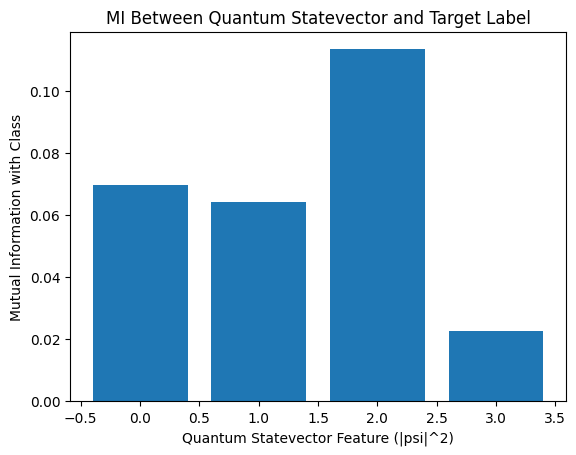

In [9]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import mutual_info_classif

features = np.abs(states)**2  # Probability distribution

# Discretize continuous features to make MI well-defined
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
features_discrete = discretizer.fit_transform(features)

# Compute mutual information between each feature dim and the label
mi_scores = mutual_info_classif(features_discrete, y)

plt.bar(range(len(mi_scores)), mi_scores)
plt.xlabel('Quantum Statevector Feature (|psi|^2)')
plt.ylabel('Mutual Information with Class')
plt.title('MI Between Quantum Statevector and Target Label')
plt.show()